<a href="https://colab.research.google.com/github/BaseKan/aiday_training_resources/blob/main/TF_ConvNets/ConvNets_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introductie


In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Dataset

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [3]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

classes = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(train_dir, d))]

We splitsen de validatieset in een validatieset en een testset.


In [4]:
for cl in classes:
  img_path = os.path.join(val_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  val, test = images[:round(len(images)*0.5)], images[round(len(images)*0.5):]

  for t in test:
    if not os.path.exists(os.path.join(base_dir, 'test', cl)):
      os.makedirs(os.path.join(base_dir, 'test', cl))
    shutil.move(t, os.path.join(base_dir, 'test', cl))

dogs: 500 Images
cats: 500 Images


In [5]:
print("{}: {} train images".format(classes[0], len(os.listdir(os.path.join(train_dir, classes[0])))))
print("{}: {} train images".format(classes[1], len(os.listdir(os.path.join(train_dir, classes[1])))))
print("{}: {} validation images".format(classes[0], len(os.listdir(os.path.join(val_dir, classes[0])))))
print("{}: {} validation images".format(classes[1], len(os.listdir(os.path.join(val_dir, classes[1])))))
print("{}: {} test images".format(classes[0], len(os.listdir(os.path.join(test_dir, classes[0])))))
print("{}: {} test images".format(classes[1], len(os.listdir(os.path.join(test_dir, classes[1])))))

dogs: 1000 train images
cats: 1000 train images
dogs: 250 validation images
cats: 250 validation images
dogs: 250 test images
cats: 250 test images


Creating an Image Data Generator

In [6]:
batch_size = 64
IMG_SHAPE = 224

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [8]:
image_gen = ImageDataGenerator(rescale=1/255)

train_data_gen = image_gen.flow_from_directory(directory = train_dir, 
                                               target_size = (IMG_SHAPE, IMG_SHAPE),
                                               batch_size = batch_size,
                                               shuffle = True)

Found 2000 images belonging to 2 classes.


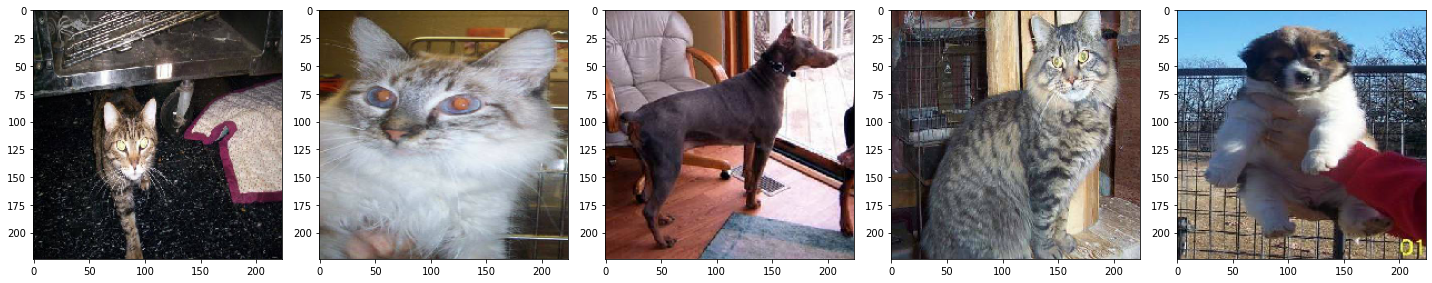

In [9]:
images = [train_data_gen[0][0][i] for i in range(5)]
plotImages(images)

# Exercise

Gebruik de documentatie van [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) om meerdere augmentaties te combineren. Train vervolgens een CNN en probeer een zo goed mogelijke score te halen op de test set.

In [10]:
image_gen_val = ImageDataGenerator(rescale=1/255)

val_data_gen = image_gen_val.flow_from_directory(directory = val_dir,
                                                 target_size = (IMG_SHAPE, IMG_SHAPE),
                                                 batch_size = batch_size)

image_gen_test = ImageDataGenerator(rescale=1/255)

test_data_gen = image_gen_test.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_SHAPE, IMG_SHAPE),
                                                   batch_size = batch_size)

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [11]:
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = image_gen.flow_from_directory(directory = train_dir, 
                                               target_size = (IMG_SHAPE, IMG_SHAPE),
                                               shuffle = True,
                                               batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [12]:
model = tf.keras.Sequential([
                             Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
                             MaxPooling2D((2,2)),

                             Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                             MaxPooling2D((2,2)),

                             Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
                             MaxPooling2D((2,2)),

                             Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
                             MaxPooling2D(2,2),

                             Dropout(0.5),
                             Flatten(),
                             Dense(512, activation='relu'),

                             Dense(len(classes))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [13]:
tf.keras.backend.clear_session()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
cross_entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = ['accuracy']
model.compile(
  optimizer=adam_optimizer,
  loss=binary_cross_entropy_loss,
  metrics=accuracy)

history = model.fit(train_data_gen,
                    epochs=50,
                    validation_data=val_data_gen
                    )

Epoch 1/50
32/32 [==============================] - 44s 391ms/step - loss: 0.6918 - accuracy: 0.5355 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 2/50
32/32 [==============================] - 11s 331ms/step - loss: 0.6719 - accuracy: 0.5785 - val_loss: 0.6462 - val_accuracy: 0.6520
Epoch 3/50
32/32 [==============================] - 10s 326ms/step - loss: 0.6302 - accuracy: 0.6555 - val_loss: 0.6522 - val_accuracy: 0.6220
Epoch 4/50
32/32 [==============================] - 11s 329ms/step - loss: 0.5828 - accuracy: 0.6910 - val_loss: 0.6075 - val_accuracy: 0.6180
Epoch 5/50
32/32 [==============================] - 11s 326ms/step - loss: 0.5584 - accuracy: 0.7100 - val_loss: 0.5955 - val_accuracy: 0.6840
Epoch 6/50
32/32 [==============================] - 10s 324ms/step - loss: 0.5260 - accuracy: 0.7495 - val_loss: 0.5581 - val_accuracy: 0.7120
Epoch 7/50
32/32 [==============================] - 11s 327ms/step - loss: 0.5213 - accuracy: 0.7370 - val_loss: 0.5625 - val_accuracy: 0.7040

In [14]:
model.evaluate(test_data_gen)

8/8 [==============================] - 2s 226ms/step - loss: 0.8111 - accuracy: 0.8020


[0.811122477054596, 0.8019999861717224]

# Transfer Learning

In [15]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))
feature_extractor.trainable = False
model = tf.keras.Sequential([
    feature_extractor,
    Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
tf.keras.backend.clear_session()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
cross_entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = ['accuracy']
model.compile(
  optimizer=adam_optimizer,
  loss=binary_cross_entropy_loss,
  metrics=accuracy)

history = model.fit(train_data_gen, epochs=10,validation_data=val_data_gen)

Epoch 1/10
32/32 [==============================] - 16s 370ms/step - loss: 0.6153 - accuracy: 0.7025 - val_loss: 0.4977 - val_accuracy: 0.8580
Epoch 2/10
32/32 [==============================] - 10s 325ms/step - loss: 0.4753 - accuracy: 0.8735 - val_loss: 0.3875 - val_accuracy: 0.9220
Epoch 3/10
32/32 [==============================] - 10s 323ms/step - loss: 0.3809 - accuracy: 0.9220 - val_loss: 0.3116 - val_accuracy: 0.9600
Epoch 4/10
32/32 [==============================] - 10s 324ms/step - loss: 0.3152 - accuracy: 0.9405 - val_loss: 0.2595 - val_accuracy: 0.9720
Epoch 5/10
32/32 [==============================] - 10s 323ms/step - loss: 0.2686 - accuracy: 0.9530 - val_loss: 0.2211 - val_accuracy: 0.9820
Epoch 6/10
32/32 [==============================] - 10s 320ms/step - loss: 0.2331 - accuracy: 0.9595 - val_loss: 0.1928 - val_accuracy: 0.9860
Epoch 7/10
32/32 [==============================] - 10s 322ms/step - loss: 0.2064 - accuracy: 0.9675 - val_loss: 0.1712 - val_accuracy: 0.9860

In [17]:
model.evaluate(test_data_gen)

8/8 [==============================] - 2s 255ms/step - loss: 0.1437 - accuracy: 0.9780


[0.14365576207637787, 0.9779999852180481]